In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [62]:
# Memuat dataset dari file CSV
df = pd.read_csv('Dataset/penjualan_barang.csv')

In [17]:
df = pd.read_csv('Dataset/penjualan_barang.csv')
print (df)

      Unnamed: 0     tanggal           nama.pembeli nama.barang  kuantum  \
0              1  2020-01-02       TOKO HERUNIAWATI       BERAS   1000.0   
1              2  2020-01-02       TOKO HERUNIAWATI      DAGING    120.0   
2              3  2020-01-02  TOKO APRILIA SUKRISNI       BERAS   6000.0   
3              4  2020-01-02  TOKO APRILIA SUKRISNI       MIGOR    408.0   
4              5  2020-01-02  TOKO APRILIA SUKRISNI      TEPUNG    140.0   
...          ...         ...                    ...         ...      ...   
1284        1285  2021-04-08        TOKO MAJU TERUS      DAGING     60.0   
1285        1286  2021-04-08            TOKO KINORA       BERAS    250.0   
1286        1287  2021-04-08            TOKO KINORA      TEPUNG    120.0   
1287        1288  2021-04-09  TOKO BERKAH DUA PUTRA        GULA    100.0   
1288        1289  2021-04-09  TOKO BERKAH DUA PUTRA      DAGING     80.0   

         nominal  
0      9840000.0  
1      8400000.0  
2     62910000.0  
3      4855

In [18]:
df.describe()

,Unnamed: 0,kuantum,nominal
count,1289.000000,1289.000000,1.289000e+03
mean,645.000000,1735.063615,1.929970e+07
std,372.246558,6300.788118,6.489967e+07
min,1.000000,2.000000,4.600000e+04
25%,323.000000,140.000000,2.964000e+06
50%,645.000000,600.000000,7.650000e+06
75%,967.000000,1800.000000,1.890000e+07
max,1289.000000,200000.000000,2.047000e+09


In [19]:
df.head()

,Unnamed: 0,tanggal,nama.pembeli,nama.barang,kuantum,nominal
0,1,2020-01-02,TOKO HERUNIAWATI,BERAS,1000.0,9840000.0
1,2,2020-01-02,TOKO HERUNIAWATI,DAGING,120.0,8400000.0
2,3,2020-01-02,TOKO APRILIA SUKRISNI,BERAS,6000.0,62910000.0
3,4,2020-01-02,TOKO APRILIA SUKRISNI,MIGOR,408.0,4855200.0
4,5,2020-01-02,TOKO APRILIA SUKRISNI,TEPUNG,140.0,1162000.0


In [20]:
df.tail()

,Unnamed: 0,tanggal,nama.pembeli,nama.barang,kuantum,nominal
1284,1285,2021-04-08,TOKO MAJU TERUS,DAGING,60.0,4389600.0
1285,1286,2021-04-08,TOKO KINORA,BERAS,250.0,2718750.0
1286,1287,2021-04-08,TOKO KINORA,TEPUNG,120.0,1065120.0
1287,1288,2021-04-09,TOKO BERKAH DUA PUTRA,GULA,100.0,1200000.0
1288,1289,2021-04-09,TOKO BERKAH DUA PUTRA,DAGING,80.0,5852800.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1289 non-null   int64  
 1   tanggal       1289 non-null   object 
 2   nama.pembeli  1289 non-null   object 
 3   nama.barang   1289 non-null   object 
 4   kuantum       1289 non-null   float64
 5   nominal       1289 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 60.6+ KB


In [63]:
# Mengubah kolom tanggal menjadi datetime
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [23]:
# Pivoting dataset untuk menghitung rata-rata kuantitas per barang per tanggal
df_pivot = df.pivot_table(index='tanggal', columns='nama.barang', values='kuantum', aggfunc='sum').fillna(0)

In [24]:
# Membuat fitur tambahan: tahun, bulan, hari
df_pivot['year'] = df_pivot.index.year
df_pivot['month'] = df_pivot.index.month
df_pivot['day'] = df_pivot.index.day

In [25]:
# Fitur Musiman
df_pivot['dayofweek'] = df_pivot.index.dayofweek
df_pivot['quarter'] = df_pivot.index.quarter
df_pivot['weekofyear'] = df_pivot.index.isocalendar().week

In [26]:
# Fitur Transformasi Waktu
df_pivot['sin_month'] = np.sin(2 * np.pi * df_pivot['month'] / 12)
df_pivot['cos_month'] = np.cos(2 * np.pi * df_pivot['month'] / 12)
df_pivot['sin_day'] = np.sin(2 * np.pi * df_pivot['day'] / 31)
df_pivot['cos_day'] = np.cos(2 * np.pi * df_pivot['day'] / 31)

In [27]:
# Membuat lagged features
df_pivot['BERAS_lag1'] = df_pivot['BERAS'].shift(1)
df_pivot['BERAS_lag2'] = df_pivot['BERAS'].shift(2)

In [28]:
# Membuat fitur moving average
df_pivot['BERAS_MA7'] = df_pivot['BERAS'].rolling(window=7).mean()
df_pivot['BERAS_MA30'] = df_pivot['BERAS'].rolling(window=30).mean()

In [29]:
# Membuat fitur perubahan harian
df_pivot['BERAS_diff1'] = df_pivot['BERAS'].diff(1)

In [30]:
# Membuat fitur musiman: apakah akhir pekan
df_pivot['is_weekend'] = df_pivot.index.dayofweek >= 5

In [31]:
# Fitur Interaksi
df_pivot['month_day_interaction'] = df_pivot['month'] * df_pivot['day']

In [32]:
# Fitur Rolling Statistics
df_pivot['BERAS_rolling_std_7'] = df_pivot['BERAS'].rolling(window=7).std()
df_pivot['BERAS_rolling_mean_14'] = df_pivot['BERAS'].rolling(window=14).mean()

In [33]:
# Fitur Transformasi Kuantum
df_pivot['BERAS_log'] = np.log1p(df_pivot['BERAS'])

In [34]:
# Drop NaN values yang dihasilkan dari lagged features dan moving average
df_pivot.dropna(inplace=True)

In [35]:
# Mengambil fitur dan target
features = ['year', 'month', 'day', 'dayofweek', 'quarter', 'weekofyear', 'sin_month', 'cos_month', 
            'sin_day', 'cos_day', 'BERAS_lag1', 'BERAS_lag2', 'BERAS_MA7', 'BERAS_MA30', 
            'BERAS_diff1', 'is_weekend', 'month_day_interaction', 'BERAS_rolling_std_7', 
            'BERAS_rolling_mean_14', 'BERAS_log']
X = df_pivot[features].values
y = df_pivot['BERAS'].values

In [36]:
# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Model yang lebih kompleks: Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [38]:
# Prediksi
y_pred = model.predict(X_test)

In [39]:
# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [40]:
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 2152945.79409375
R-squared (R2): 0.9873189114163113


In [41]:
# Grid Search untuk Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [42]:
# Model Random Forest
model = RandomForestRegressor(random_state=42)

In [43]:
# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [44]:
# Model terbaik
best_model = grid_search.best_estimator_

In [45]:
# Prediksi dengan model terbaik
y_pred = best_model.predict(X_test)

In [46]:
# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [47]:
print(f'Mean Squared Error (MSE) setelah tuning: {mse}')
print(f'R-squared (R2) setelah tuning: {r2}')
print(f'Best Parameters: {grid_search.best_params_}')

Mean Squared Error (MSE) setelah tuning: 733878.3209776145
R-squared (R2) setelah tuning: 0.9956773756108972
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


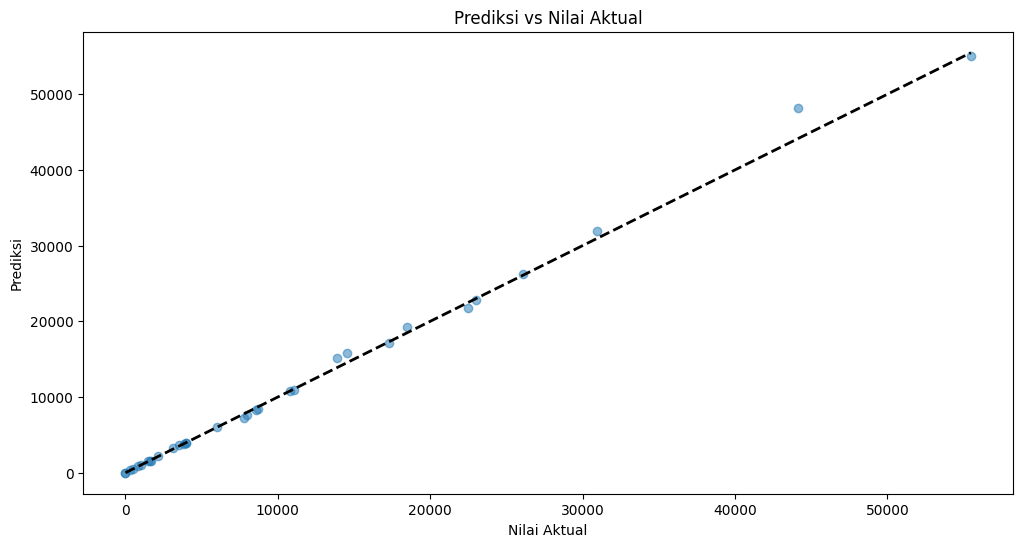

In [48]:
# Visualisasi Prediksi vs. Nilai Aktual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Nilai Aktual')
plt.ylabel('Prediksi')
plt.title('Prediksi vs Nilai Aktual')
plt.show()

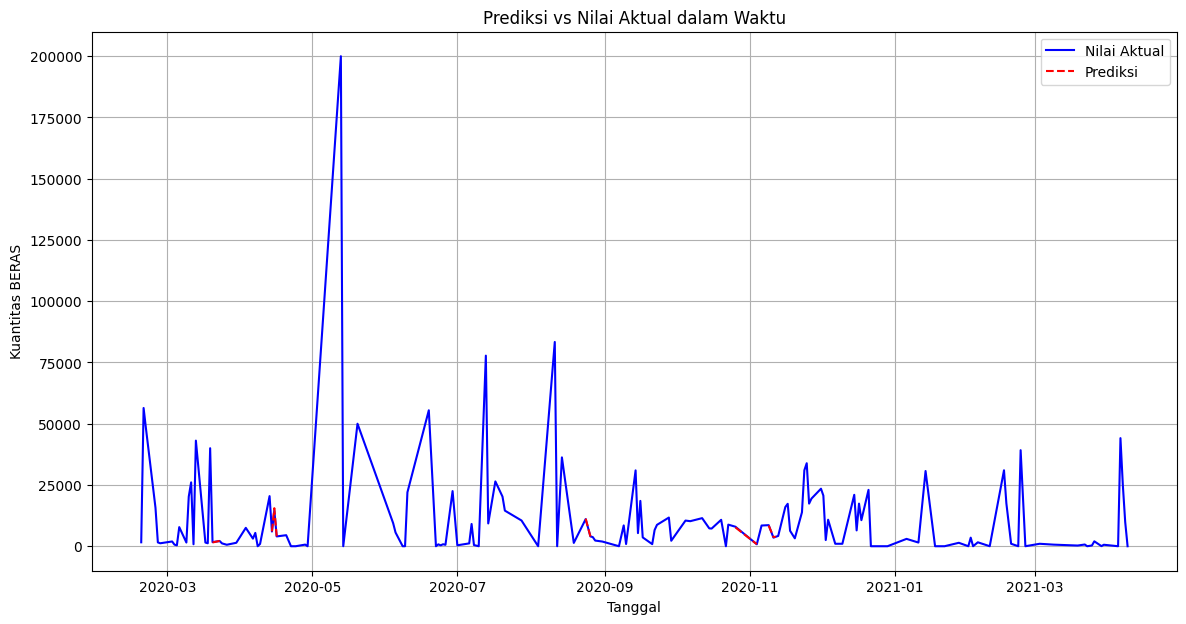

In [77]:
# Menyimpan indeks asli
df_pivot['original_index'] = df_pivot.index

# Mengambil fitur dan target
features = ['year', 'month', 'day', 'dayofweek', 'quarter', 'weekofyear', 'sin_month', 'cos_month', 
            'sin_day', 'cos_day', 'BERAS_lag1', 'BERAS_lag2', 'BERAS_MA7', 'BERAS_MA30', 
            'BERAS_diff1', 'is_weekend', 'month_day_interaction', 'BERAS_rolling_std_7', 
            'BERAS_rolling_mean_14', 'BERAS_log']
X = df_pivot[features].values
y = df_pivot['BERAS'].values

# Membagi data menjadi train dan test
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(X, y, df_pivot['original_index'], test_size=0.2, random_state=42)

# Model yang lebih kompleks: Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Menambahkan kolom Prediksi ke dataset df_pivot
df_pivot['Prediksi'] = np.nan

# Mengisi kolom Prediksi dengan nilai dari model
df_pivot.loc[test_index, 'Prediksi'] = y_pred

# Visualisasi Prediksi dan Nilai Aktual dalam Waktu
plt.figure(figsize=(14, 7))

# Plot Nilai Aktual
plt.plot(df_pivot.index, df_pivot['BERAS'], label='Nilai Aktual', color='blue')

# Plot Prediksi
plt.plot(df_pivot.index, df_pivot['Prediksi'], label='Prediksi', color='red', linestyle='--')

# Menambahkan judul dan label
plt.title('Prediksi vs Nilai Aktual dalam Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Kuantitas BERAS')
plt.legend()
plt.grid(True)
plt.show()
